In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import pickle
import obspy
from scipy.signal import find_peaks
import os
import pandas as pd

import cmcrameri.cm as cmc

from matplotlib import patches


In [2]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined.csv')

In [3]:
def moment_in_different_windows(window = None, window_prop = None):
    if window is None and window_prop is None:
        window_prop = 1

    diff = []
    moments = []

    romb = []
    simpson = []
    trapz = []

    simpson_short = []

    durations = []

    for scardec_name in os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec'):
        db = combined[combined['scardec_name']==scardec_name]

        time_opt = []
        momentrate_opt = []

        time_moy = []
        momentrate_moy = []

        event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
        starts = [n for n, l in enumerate(event) if l.startswith('fctopt')]
        with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
            lines = f.read().splitlines()

        lines = lines[2:]
        for line in lines:
            split = line.split(' ')
            split = [s for s in split if s not in ['', ' ', '\n']]
            time_opt.append(float(split[0]))
            momentrate_opt.append(float(split[1]))

        momentrate_opt = np.array(momentrate_opt)

        not_zero = np.where(momentrate_opt > 0)[0]

        start = min(not_zero)
        end = max(not_zero)
        duration = time_opt[end] - time_opt[start]
        durations.append(duration)

        simpson.append(scipy.integrate.simpson(momentrate_opt[start:end], dx = time_opt[1]-time_opt[0]))
        trapz.append(scipy.integrate.trapezoid(momentrate_opt, dx = time_opt[1]-time_opt[0]))
        moments.append(db['moment'].values[0])

        if window_prop is None: #using static time window
            end_window = int((end-start)*(window/duration))
        else: #based on proportion of duration
            end_window = int((end-start)*window_prop)

        simpson_short.append(scipy.integrate.simpson(momentrate_opt[start:start + end_window], dx = time_opt[1]-time_opt[0]))
    return moments, simpson, simpson_short, trapz, durations

In [4]:
def get_stf(scardec_name, wanted_type = 'fctopt'):
    db = combined[combined['scardec_name']==scardec_name]

    time = []
    momentrate = []

    event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
    starts = [n for n, l in enumerate(event) if l.startswith(wanted_type)]
    with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
        lines = f.read().splitlines()

    lines = lines[2:]
    for line in lines:
        split = line.split(' ')
        split = [s for s in split if s not in ['', ' ', '\n']]
        time.append(float(split[0]))
        momentrate.append(float(split[1]))

    momentrate = np.array(momentrate)
    return momentrate, time, db

In [250]:
# looks for time value of root
def f3(end_time, total_moment, time_opt, momentrate_opt, start, points_before_zero, proportion = 0.1):
    dx = time_opt[1]-time_opt[0]
    end_window = (end_time/dx)+points_before_zero
    end = int(np.floor(end_window))
    short = scipy.integrate.simpson(momentrate_opt[start:end], dx = dx)
    return short-(total_moment*proportion)

In [254]:
durations = []
root_times = []

proportion = 0.1

diff = []
moments = []

for i in range(0, 100):

    print(i)
    scardec_name = os.listdir('/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec')[i]
    print(scardec_name)
    momentrate_opt, time_opt, db = get_stf(scardec_name)

    not_zero = np.where(momentrate_opt > 0)[0]

    dx = time_opt[1]-time_opt[0]

    start = min(not_zero)
    end = max(not_zero)
    points_before_zero = abs(min(time_opt)/dx)

    duration = time_opt[end] - time_opt[start]
    durations.append(duration)

    start_time = time_opt[start]
    end_time = time_opt[end]

    total_moment = scipy.integrate.simpson(momentrate_opt[start:end], dx = time_opt[1]-time_opt[0])
    moments.append(total_moment)
    root, r = scipy.optimize.bisect(f3,
                                    start_time+dx,
                                    end_time,
                                    rtol = 1e-6,
                                    full_output = True,
                                    args = (total_moment,
                                            time_opt,
                                            momentrate_opt,
                                            start,
                                            points_before_zero,
                                            proportion,))
    root_idx = np.floor(root/dx)
    root_time = root_idx*dx
    root_times.append(root_time)

0
FCTs_20170818_025925_NORTH_OF_ASCENSION_ISLAND
17 0.0703125 297 19.7578125
18.0
17 18
297.0
17 297
157.5
17 157
87.75
17 87
122.625
17 122
105.1875
17 105
96.46875
17 96
92.109375
17 92
89.9296875
17 89
91.01953125
17 91
90.474609375
17 90
90.2021484375
17 90
90.06591796875
17 90
89.997802734375
17 89
90.0318603515625
17 90
90.01483154296875
17 90
90.00631713867188
17 90
90.00205993652344
17 90
89.99993133544922
17 89
90.00099563598633
17 90
90.00046348571777
17 90
90.0001974105835
17 90
90.00006437301636
17 90
89.99999785423279
17 89
1
FCTs_20110126_154229_NORTHERN_SUMATRA__INDONESIA
17 0.0703125 180 11.53125
18.0
17 18
180.0
17 180
99.0
17 99
58.5
17 58
78.75
17 78
68.625
17 68
63.5625
17 63
66.09375
17 66
64.828125
17 64
65.4609375
17 65
65.77734375
17 65
65.935546875
17 65
66.0146484375
17 66
65.97509765625
17 65
65.994873046875
17 65
66.0047607421875
17 66
65.99981689453125
17 65
66.00228881835938
17 66
66.00105285644531
17 66
66.00043487548828
17 66
66.00012588500977
17 66
65.9

Text(0.5, 0, '10% of moment time (s)')

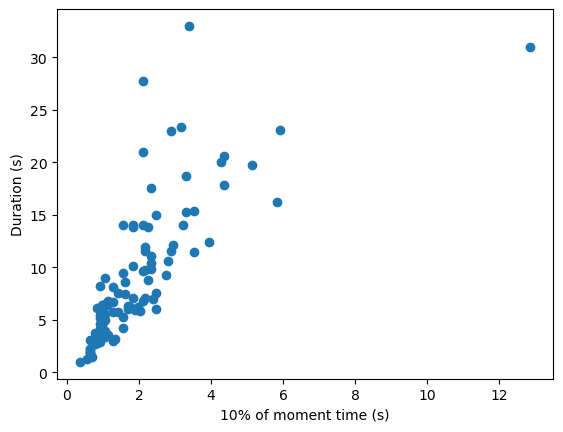

In [256]:
plt.scatter(root_times, durations)
plt.ylabel('Duration (s)')
plt.xlabel('10% of moment time (s)')

Text(0.5, 0, 'time to release 10% of moment')

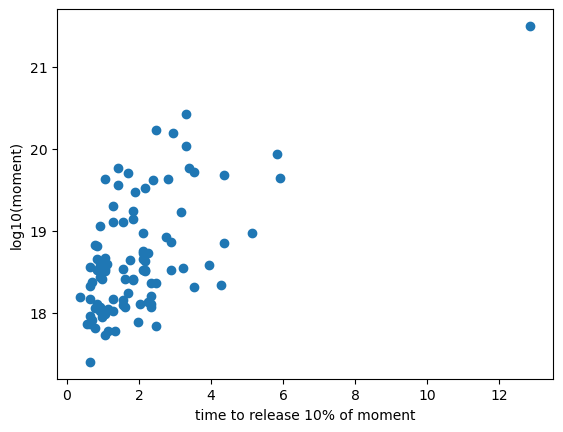

In [260]:
plt.scatter(root_times, np.log10(moments))
plt.ylabel('log10(moment)')
plt.xlabel('time to release 10% of moment')